## Digital Image Processing, ECE419

Ernesto Colon

The Cooper Union Department of Electrical Engineering

March 13th, 2021

References:
- Digital Image Processing Using Matlab [DIPUM] by Gonzalez et al., 3rd ed
- Digital Image Processing by Gonzalez et al., 4th ed

**The following set of notes and example scripts are part of my independent study sessions and adapted from the
references outlined above. My main reference is DIPUM and complemented with online documentation. As I go through the
theory and textbook examples, I am translating the code and image processing techniques to Python.**

## Image Segmentation Notes / Exercises

In [1]:
# Import libraries
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import ec_img_utils
import skimage.util
from skimage import io
from matplotlib import colors
from scipy.ndimage import convolve

In this section, we shift our attention from image processing techniques were both the input and output of our system
are images. Instead, we now seek to extract features or attributes from our input images. In particular, we will consider
segmentation, which consists of subdividing our image into regions.

First, we will explore point, lines, and edge detection which is a way to segment an image based on sharp or abrupt
transitions in the image's intensity values. Edge detection can be considered an image segmentation technique based on
intensity discontinuities.

**Some background**

Mathematically, we can represent segmentation as a process that partitions an image into $n$ subregions that satisfy the
following properties, where $R$ is the entire spatial region occupied by the image [DIPUM]:

a) $\bigcup\limits_{i=1}^{n} R_{i} = R$.

b) $R-i$ is a connected set for $i = 0, 1, 2, ..., n$.

c) $R_i \cap R_j = \emptyset$ for all valid values of $i$ and $j$, $i \neq j$.

d) $Q(R_i) = TRUE$ for $i = 0, 1, 2, ..., n$.

e) $Q(R_i \cup R_j) = FALSE$ for all adjacent regions $R_i$ and $R_j$.

Where $Q(R_k)$ is a *logical* *predicate* defined over the elements in the set $R_k$. For example, $Q$ can be a compound
predicate such as: $Q(R_i) = TRUE$ is the average intensity of the pixels in region $R_i$ is less than $m_i$ AND if the
standard deviation of the intensity values is greater than $\sigma_i$.

### Point, Line, and Edge Detection

Our main tools for segmenting points, lines, and edges in this section are derivative operators. For an image or digital
function, derivatives are computed as *finite differences*. [DIP] goes into details about deriving appropriate finite
difference equations to compute derivatives, but let's summarize the main findings here.

1) First-order derivatives generally produce thicker edges.

2) Second-order derivatives have a stronger response to fine detail, such as thin lines, isolated points, and noise.

3) Second-order derivatives produce a double-edge response at ramp and step transitions in intensity.

4) The sign of the second derivative can be used to determine whether a transition into an edge is from light to dark
(negative second-derivative) or dark to light (positive second derivative).

**Detection of Isolated Points**

Based on the conclusions summarized above, we can detect isolated points using the second derivative. We use the Laplacian
operator defined as:

\begin{equation}
\nabla^2\boldsymbol{f}(x,y) = \frac{\partial^2 f}{\partial x^2} f(x,y) + \frac{\partial^2 f}{\partial y^2} f(x,y)
\end{equation}

We can compute the Laplacian of an image using the Laplacian kernel shown below.

\begin{equation}
Lk  = \begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}
\end{equation}

We can then say that a point has been detected at location $(x,y)$ if the absolute value of the filter's response at that
location exceeds a specified threshold.

\begin{equation}
g(x,y) =
  \begin{cases}
                                   1 & \text{if}~~|Z(x,y)| \gt T \\
                                   0 & \text{otherwise}
  \end{cases}
\end{equation}

Let's find an isolated point... We will load an image with an artifact visible as a single black pixel in a jet turbine,
and try to isolate it.

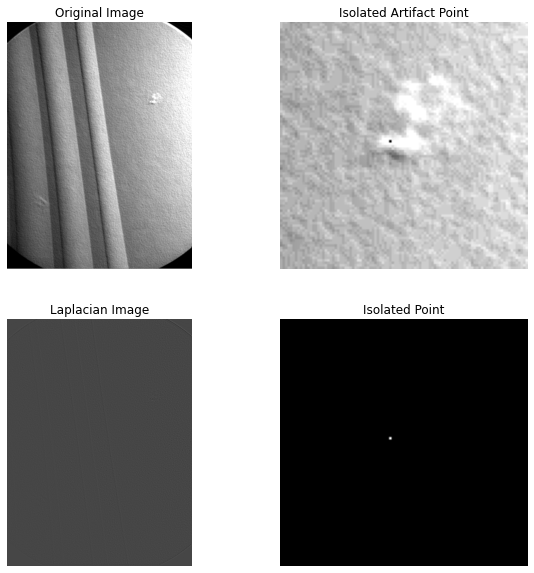

In [2]:
# load image
img_turbine = skimage.img_as_float(io.imread('./images/turbine_blade_black_dot.tif'))
img_turb_artifact = img_turbine[200:300, 400:500]

# define Laplacian kernel
lapl_krnl = (1/8) * np.array([[1, 1, 1],
                      [1, -8, 1],
                      [1, 1, 1]], dtype=np.float)

# compute the Laplacian
img_turb_lapl = convolve(img_turbine, lapl_krnl)

# threshold to isolate point

# compute threshold as 90% of the maximum value
thresh = 0.9 * np.max(np.abs(img_turb_lapl))

# produce threshold image
img_turb_point = np.where(img_turb_lapl > thresh, 1, 0)
img_turb_point = img_turb_point[200:300, 400:500]

# display images
ec_img_utils.gray_img_comparison_plot({'nrow' : 2,
                'ncol' : 2,
                'figsize' : (10, 10),
                'images' : [img_turbine, img_turb_artifact, img_turb_lapl, img_turb_point],
                'titles' : ['Original Image', 'Isolated Artifact Point', 'Laplacian Image', 'Isolated Point']})

Note in the example above how we were able to isolate a single artifact point from our image. These type of operations
are useful when we know we have isolated points and trying to find artifacts or faults, but the approach is very crude
since the Laplacian of an image is very sucesptible to noise.


**Line Detection**

We can also use the Laplacian operator to detect lines in our images. From the conclusions summarized above, we know that
second derivatives tend to produce thinner lines than first derivatives, but they also produce double-edges. Let's take
a look at an example.

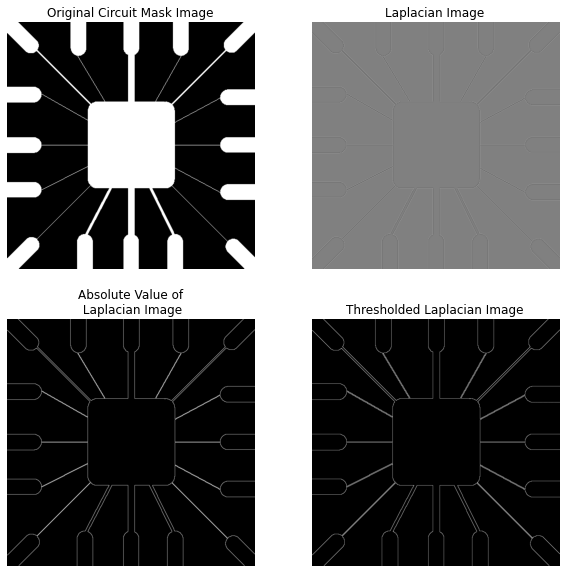

In [3]:
# load circuit mask image
img_ckt = skimage.img_as_float(io.imread('./images/circuitmask.tif'))

# compute the Laplacian of our circuit mask image
img_ckt_lapl = convolve(img_ckt, lapl_krnl)

# take the absolute value of the Laplacian image, for experimentation
img_ckt_lapl_abs = np.abs(img_ckt_lapl)

# threshold the image instead
img_ckt_lapl_thresh = np.where(img_ckt_lapl > 0.0, 1, 0)

# display the images
ec_img_utils.gray_img_comparison_plot({'nrow' : 2,
                'ncol' : 2,
                'figsize' : (10, 10),
                'images' : [img_ckt, img_ckt_lapl, img_ckt_lapl_abs, img_ckt_lapl_thresh],
                'titles' : ['Original Circuit Mask Image', 'Laplacian Image',
                            'Absolute Value of\n Laplacian Image', 'Thresholded Laplacian Image']})

Let's compute the difference between the absolute value of the Laplacian image and the thresholded binary edge map.


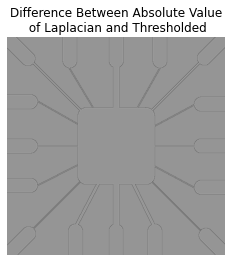

In [4]:
img_ckt_edge_diff = img_ckt_lapl_abs - img_ckt_lapl_thresh
plt.figure()
plt.imshow(img_ckt_edge_diff, cmap='gray')
plt.title("Difference Between Absolute Value\n of Laplacian and Thresholded")
plt.axis('off');

Let's zoom into an area of interest to check what is happening with our image processing operations.

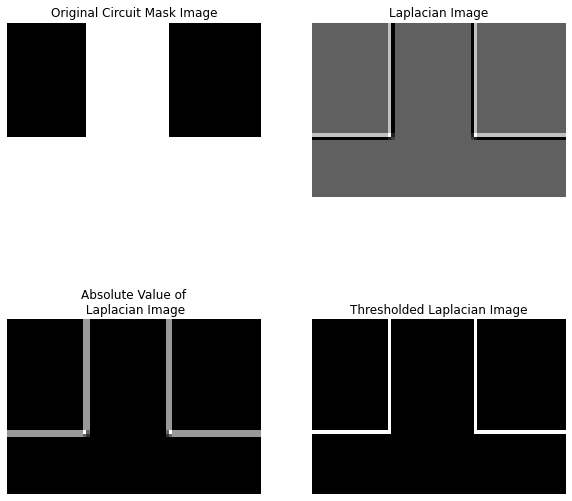

In [5]:
img_ckt_zooms = [img_ckt[280:335, 450:530],
                 img_ckt_lapl[280:335, 450:530],
                 img_ckt_lapl_abs[280:335, 450:530],
                 img_ckt_lapl_thresh[280:335, 450:530]]

# display the images
ec_img_utils.gray_img_comparison_plot({'nrow' : 2,
                'ncol' : 2,
                'figsize' : (10, 10),
                'images' : img_ckt_zooms,
                'titles' : ['Original Circuit Mask Image', 'Laplacian Image',
                            'Absolute Value of\n Laplacian Image', 'Thresholded Laplacian Image']})

Note from the zoomed images displayed above that computing the absolute value of our Laplacian image produces a grayscale
image and not a clear delineation between what's an edge and what is not an edge. When the latter is needed, we're better
off thresholding our image as shown in the example above.

**Detecting lines in specified directions**

In the example outlined above, the Laplacian kernel is isotropic. That is, its response is independent of direction.
Sometimes we are interested in finding edges along a particular direction. For example, we can define the following
kernels and their associated directions.

*Horizontal*

\begin{equation}
k_{hor} = \begin{bmatrix}
-1 & -1 & -1\\
2 & 2 & 2\\
-1 & -1 & -1
\end{bmatrix}
\end{equation}

$+45^{\circ}$

\begin{equation}
k_{+45} = \begin{bmatrix}
2 & -1 & -1\\
-1 & 2 & -1\\
-1 & -1 & 2
\end{bmatrix}
\end{equation}


*Vertical*

\begin{equation}
k_{ver} = \begin{bmatrix}
-1 & 2 & -1\\
-1 & 2 & -1\\
-1 & 2 & -1
\end{bmatrix}
\end{equation}

$-45^{\circ}$

\begin{equation}
k_{-45} = \begin{bmatrix}
-1 & -1 & 2\\
-1 & 2 & -1\\
2 & -1 & -1
\end{bmatrix}
\end{equation}

Let's try these kernels out with our circuit mask image...

In [6]:
def directional_laplacian_krnl(dir='isotropic'):
    """
    Function to return a Laplacian kernel given a direction string
    @param dir: string specifying Laplacian kernel's direction
    @return: 3x3 ndarray with Laplacian kernel
    """

    if dir == 'isotropic':
        krnl = np.array([[1, 1, 1],
                        [1, -8, 1],
                        [1, 1, 1]], dtype=np.float)

    if dir == 'horizontal':
        krnl = np.array([[-1, -1, -1],
                        [2, 2, 2],
                        [-1, -1, -1]], dtype=np.float)

    if dir == 'vertical':
        krnl = np.array([[-1, 2, -1],
                        [-1, 2, -1],
                        [-1, 2, -1]], dtype=np.float)

    if dir == 'pos_45':
        krnl = np.array([[2, -1, -1],
                         [-1, 2, -1],
                         [-1, -1, 2]], dtype=np.float)

    if dir == 'neg_45':
        krnl = np.array([[-1, -1, 2],
                         [-1, 2, -1],
                         [2, -1, -1]], dtype=np.float)

    return krnl

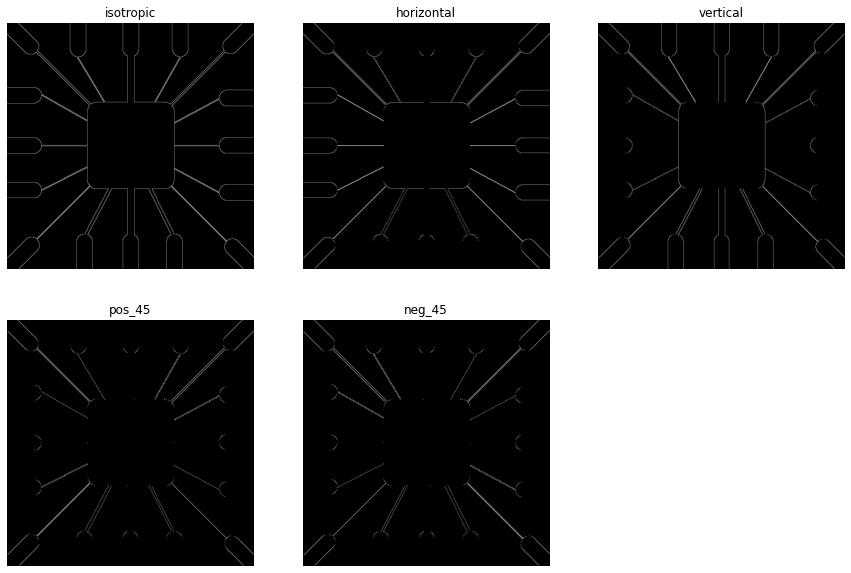

In [7]:
# Detect lines in multiple directions
directions = ['isotropic', 'horizontal', 'vertical', 'pos_45', 'neg_45']

ckt_lines_lst = list()

for dir in directions:

    # compute the Laplacian
    lpl = convolve(img_ckt, directional_laplacian_krnl(dir))

    #threshold
    lpl = np.where(lpl > 0, 1, 0)

    # store
    ckt_lines_lst.append(lpl)

# display results
ec_img_utils.gray_img_comparison_plot({'nrow' : 2,
                'ncol' : 3,
                'figsize' : (15, 10),
                'images' : ckt_lines_lst,
                'titles' : directions})

Note how the horizontal and vertical Laplacian responses vary in the directions of maximum responses. The horizontal
Laplacian edge map contains pronounced horizontal lines in our circuit mask and the opposite is true for our vertical
lines map. Similarly, we see that the positive and negative $45^{\circ}$ line maps have opposite regions of maximum
intensity.

If we repeat the experiment, but this time thresholding with a higher value, we can be more aggressive and separate the
lines along the individual directions more.

**Edge Detection**

As described previously, edge detection is a form of image segmentation based on intensity discontinuities. In edge
detection, objects or regions in the image are differentiated from the background by detecting their boundaries.

The first and second order derivatives of an image are used to detect the intensity discontinuities. We can compute the
first-order derivative with the gradient operator. The gradient of a 2D function $f(x,y)$ is defined as:

\begin{equation}
\nabla[\boldsymbol{f}(x,y)] =
\begin{bmatrix} g_x \\ g_y \end{bmatrix} =
\begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{bmatrix}
\end{equation}

The magnitude of the gradient is defined as:

\begin{equation}
|\nabla\boldsymbol{f}(x,y)| = [g_x^2 + g_y^2]^{1/2} \approx |g_x| + |g_y|
\end{equation}

and the direction of maximum rate of change can be found as the arctangent of the vertical to the horizontal gradients.
Note that this is a *four-quadrant* arctangent.

\begin{equation}
\alpha(x,y) = tan^{-1}\frac{g_y}{g_x}
\end{equation}

Second-order derivatives for image processing are usually computed using the *Laplacian* operator. The Laplacian of a 2D
function $f(x,y)$ is defined as:

\begin{equation}
\nabla^2\boldsymbol{f}(x,y) = \frac{\partial^2 f}{\partial x^2} f(x,y) + \frac{\partial^2 f}{\partial y^2} f(x,y)
\end{equation}

As described in [DIPUM], the Laplacian of an image is highly sensitive to noise, and its magnitude is prone to producing
double edges. However, it is still used as a pre-processing step in more advanced edge detection algorithms.

#### Sobel Edge Detector

The Sobel edge detector approximates the first-order derivatives as discrete differences in a small pixel neighborhood
as shown below.

\begin{equation}
Neighborhood = \begin{bmatrix}
z_1 & z_2 & z_3\\
z_4 & z_5 & z_6\\
z_7 & z_8 & z_9
\end{bmatrix}
\end{equation}

\begin{equation}
g_x = (z_1 + 2z_2 + z_3) - (z_7 + 2z_8 + z_9)
\end{equation}

\begin{equation}
g_y = (z_1 + 2z_4 + z_7) - (z_3 + 2z_6 + z_9)
\end{equation}

And the corresponding Sobel kernels are as shown below.

\begin{equation}
Sobel_x = \begin{bmatrix}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
\end{equation}

\begin{equation}
Sobel_y = \begin{bmatrix}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1
\end{bmatrix}
\end{equation}

We can compute the gradient as the square root of the sum in quadrature of the x- and y-gradients as outlined above.

Let's try this out... First, let's compute the gradient images in the horizontal and vertical directions.

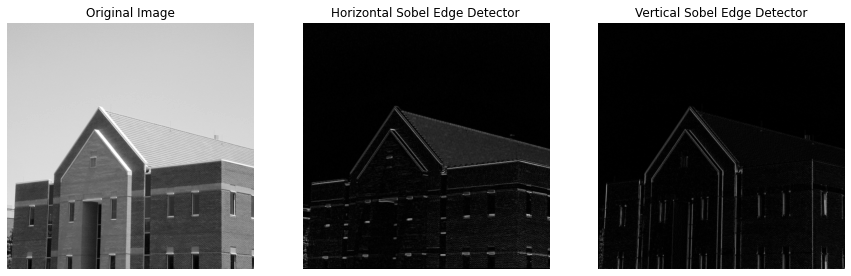

In [8]:
# Load building image
img_building = io.imread('./images/building.tif')

# compute the horizontal gradient image
img_bld_hor_sobel = skimage.filters.sobel_h(img_building)

# compute the vertical gradient image
img_bld_ver_sobel = skimage.filters.sobel_v(img_building)

# compute the absolute value of the gradient images
img_bld_hor_sobel = np.abs(img_bld_hor_sobel)
img_bld_ver_sobel = np.abs(img_bld_ver_sobel)

# display the results
ec_img_utils.gray_img_comparison_plot({
                                    'nrow' : 1,
                                    'ncol' : 3,
                                    'figsize' : (15, 5),
                                    'images' : [img_building, img_bld_hor_sobel, img_bld_ver_sobel],
                                    'titles' : ['Original Image',
                                                'Horizontal Sobel Edge Detector',
                                                'Vertical Sobel Edge Detector']})

As expected, and as seen from our lines example above, the horizontal and vertical edges have been extracted using
appropriate Sobel kernels. Combining these two operations results in a more robust edge detection algorithm.

**Custom Sobel Edge Detector**

In [9]:
def edge_sobel(img, thresh=0):
    """
    Function to perform edge detection on an input grayscale image using a Sobel kernel
    @param thresh: float with threshold parameter
    @param img: ndarray-like grayscale image or channel. This function assumes a single channel image. If RGB is needed,
                individual channels may be computed individually.
    @return:    ndarray-like edge map. Same dimensions as the input image
    """

    # convert image to float, just in case
    img = skimage.img_as_float(img)

    # Compute gradients in x and y direction using a Sobel filter
    grad_x = skimage.filters.sobel(img, axis=0, mode='reflect')
    grad_y = skimage.filters.sobel(img, axis=1, mode='reflect')

    # compute gradient magnitude
    sobel_edge = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))

    if thresh != 0:
        sobel_edge = sobel_edge > thresh

    return sobel_edge

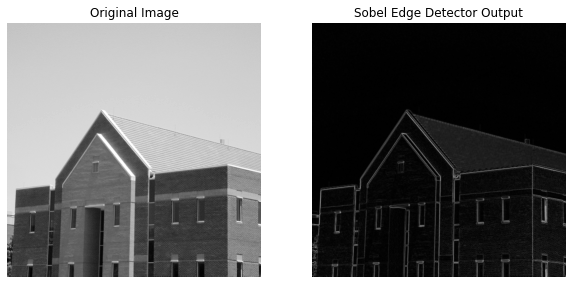

In [10]:
# Test my sobel edge detector

# perform Sobel edge detection
img_build_edge_sob = edge_sobel(img_building)

# display the images
sobel_params = {'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_building, img_build_edge_sob],
                'titles' : ['Original Image', 'Sobel Edge Detector Output']}

ec_img_utils.gray_img_comparison_plot(sobel_params)

#### Prewitt Edge Detector

The Prewitt edge detector approximates the first-order derivatives as discrete differences in a small pixel neighborhood
as shown below:

\begin{equation}
Neighborhood = \begin{bmatrix}
z_1 & z_2 & z_3\\
z_4 & z_5 & z_6\\
z_7 & z_8 & z_9
\end{bmatrix}
\end{equation}

\begin{equation}
g_x = (z_1 + z_2 + z_3) - (z_7 + z_8 + z_9)
\end{equation}

\begin{equation}
g_y = (z_1 + z_4 + z_7) - (z_3 + z_6 + z_9)
\end{equation}

and the corresponding Prewitt kernels are as shown below.

\begin{equation}
Prewitt_x = \begin{bmatrix}
1 & 1 & 1\\
0 & 0 & 0\\
-1 & -1 & -1
\end{bmatrix}
\end{equation}

\begin{equation}
Prewitt_y = \begin{bmatrix}
1 & 0 & -1\\
1 & 0 & -1\\
1 & 0 & -1
\end{bmatrix}
\end{equation}

We can compute the gradient as the square root of the sum in quadrature of the x- and y-gradients as outlined above.

Let's try it out...

**Custom Prewitt Edge Detector**

In [11]:
def edge_prewitt(img, thresh=0):
    """
    Function to perform edge detection on an input grayscale image using a Prewitt kernel
    @param thresh: float with threshold parameter
    @param img: ndarray-like grayscale image or channel. This function assumes a single channel image. If RGB is needed,
                individual channels may be computed individually.
    @return:    ndarray-like edge map. Same dimensions as the input image
    """

    # convert image to float, just in case
    img = skimage.img_as_float(img)

    # Compute gradients in x and y direction using a Sobel filter
    grad_x = skimage.filters.prewitt(img, axis=0, mode='reflect')
    grad_y = skimage.filters.prewitt(img, axis=1, mode='reflect')

    # compute gradient magnitude
    prewitt_edge = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))

    if thresh != 0:
        prewitt_edge = prewitt_edge > thresh

    return prewitt_edge

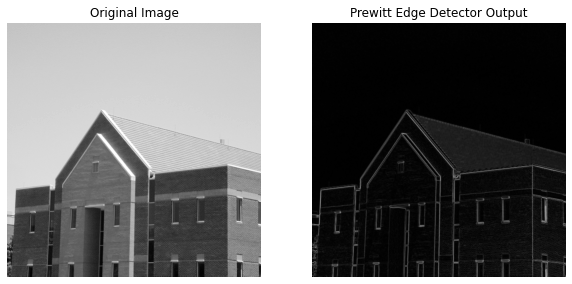

In [12]:
# Test my Prewitt edge detector

# perform Prewitt edge detection
img_build_edge_prewitt = edge_prewitt(img_building)

# display the images
prewitt_params = {'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_building, img_build_edge_prewitt],
                'titles' : ['Original Image', 'Prewitt Edge Detector Output']}

ec_img_utils.gray_img_comparison_plot(prewitt_params)

Let's compare the Sobel and Prewitt Edge Detectors. Let's compute the absolute difference between the two edge maps

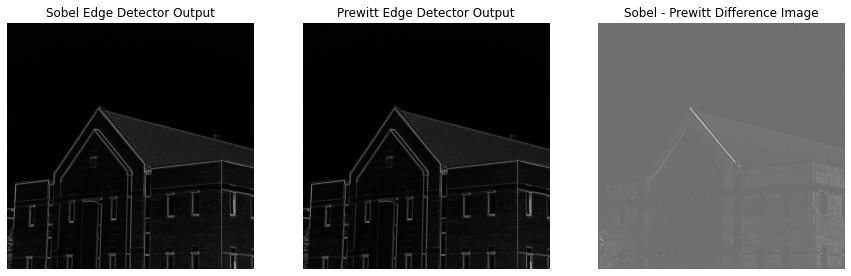

In [13]:
# compute the difference between the Sobel and Prewitt edge detectors
sobel_prewitt_diff = ec_img_utils.normalize_zero_one(img_build_edge_sob - img_build_edge_prewitt)

# display the images
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 3,
                'figsize' : (15, 5),
                'images' : [img_build_edge_sob, img_build_edge_prewitt, sobel_prewitt_diff],
                'titles' : ['Sobel Edge Detector Output', 'Prewitt Edge Detector Output',
                            'Sobel - Prewitt Difference Image']})

Note that even though it is a bit difficult to discern the difference between the Sobel and Prewitt edge maps, they are
indeed different. My approach to visualize the difference consists in computing the difference between the two edge maps
and normalizing the result between [0, 1] to display the results. Note how the diagonal at the top of the building is
very prominent in the difference image.

Also, note how we the outer walls of the building are clearly visible in the difference image. This indicates that our
edge map is not just outlining the building boundary, but it also contains local details that we may not be interested
in. We'll see more robust techniques later. One common way to mitigate some of the local details like the concrete wall
is to smooth the image prior to performing edge detection. This results in a **less noisy** image prior to edge detection.

**Smoothing prior to edge detection**

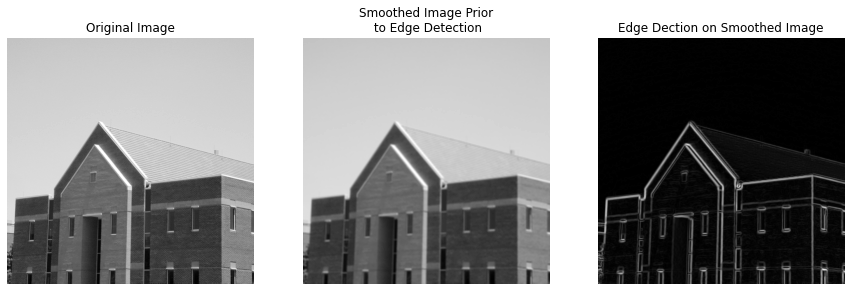

In [14]:
# smooth building image first
img_bld_smooth = convolve(img_building, (1/25) * np.ones((5,5)))

# perform edge detection now
img_bldg_smooth_edge = np.abs(edge_sobel(img_bld_smooth))

# display the results
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 3,
                'figsize' : (15, 5),
                'images' : [img_building, img_bld_smooth, img_bldg_smooth_edge],
                'titles' : ['Original Image', 'Smoothed Image Prior\n to Edge Detection',
                            'Edge Dection on Smoothed Image']})

Note from the example above that our building edges are more pronounced and we maintain less detail in the concrete walls
compared to the results we obtained without smoothing the image first. Usually, smoothing and thresholding are combined
to achieve a particular level of performance needed.

#### Roberts Edge Detector

The Roberts edge detector approximates the first-order derivatives as discrete differences in a small pixel neighborhood
as shown below. The Roberts edge detector is one of the oldest and crudest edge detectors and not too commonly used [DIPUM].

\begin{equation}
Neighborhood = \begin{bmatrix}
z_1 & z_2 & z_3\\
z_4 & z_5 & z_6\\
z_7 & z_8 & z_9
\end{bmatrix}
\end{equation}

\begin{equation}
g_x = (z_5 - z_9)
\end{equation}

\begin{equation}
g_y = (z_6 - z_8)
\end{equation}

and the corresponding Roberts kernels are as shown below.

\begin{equation}
Roberts_x = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
\end{equation}

\begin{equation}
Roberts_y = \begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}
\end{equation}

We can compute the gradient as the square root of the sum in quadrature of the x- and y-gradients as outlined above.

Let's try it out...

**Custom Roberts Edge Detector**

In [15]:
def edge_roberts(img, thresh=0):
    """
    Function to perform edge detection on an input grayscale image using a Roberts kernel
    @param thresh: float with threshold parameter
    @param img: ndarray-like grayscale image or channel. This function assumes a single channel image. If RGB is needed,
                individual channels may be computed individually.
    @return:    ndarray-like edge map. Same dimensions as the input image
    """

    # convert image to float, just in case
    img = skimage.img_as_float(img)

    # Compute gradients in x and y direction using a Sobel filter
    grad_x = skimage.filters.roberts_pos_diag(img)
    grad_y = skimage.filters.roberts_neg_diag(img)

    # compute gradient magnitude
    roberts_edge = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))

    if thresh != 0:
        roberts_edge = roberts_edge > thresh

    return roberts_edge

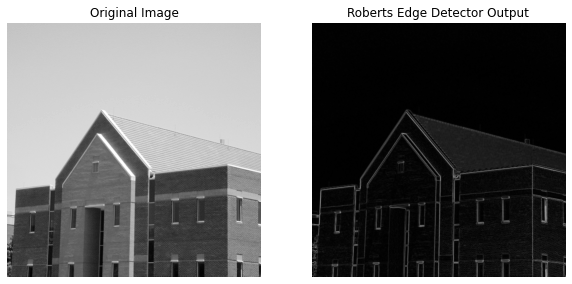

In [16]:
# Test my Roberts edge detector

# perform Prewitt edge detection
img_build_edge_roberts = edge_prewitt(img_building)

# display the images
roberts_params = {'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_building, img_build_edge_roberts],
                'titles' : ['Original Image', 'Roberts Edge Detector Output']}

ec_img_utils.gray_img_comparison_plot(roberts_params)

Compute the difference images between the Sobel-Roberts and Prewitt-Roberts pairs

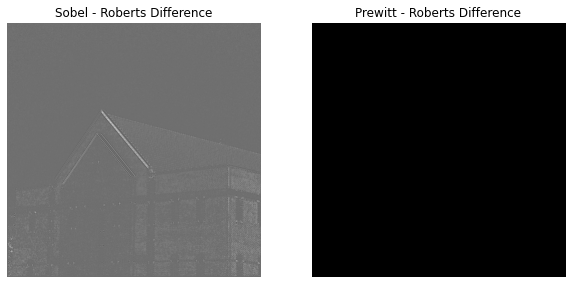

In [17]:
# compute differences
sobel_roberts_diff = img_build_edge_sob - img_build_edge_roberts
prewitt_roberts_diff = img_build_edge_prewitt - img_build_edge_roberts

# display the difference images
ec_img_utils.gray_img_comparison_plot(
                {'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [sobel_roberts_diff, prewitt_roberts_diff],
                'titles' : ['Sobel - Roberts Difference', 'Prewitt - Roberts Difference']})

Interestingly, in this example, the Prewitt edge detector and the Roberts edge detector product the same results. Let's
use a different image to verify that the three edge detectors produce different results.

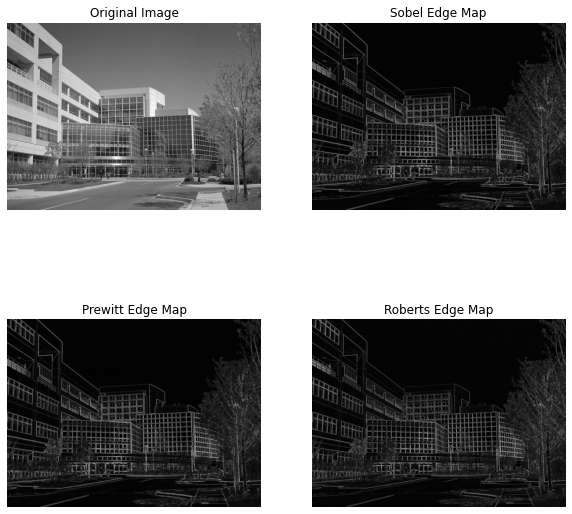

In [18]:
# load nationla archives image
img_nat_arch = io.imread('./images/national-archives-bld.tif')

# compute edge maps
nat_arch_edge_maps = []

nat_arch_edge_maps.append(img_nat_arch)
nat_arch_edge_maps.append(edge_sobel(img_nat_arch))
nat_arch_edge_maps.append(edge_prewitt(img_nat_arch))
nat_arch_edge_maps.append(edge_roberts(img_nat_arch))

# display the edge maps
ec_img_utils.gray_img_comparison_plot(
                {'nrow' : 2,
                'ncol' : 2,
                'figsize' : (10, 10),
                'images' : nat_arch_edge_maps,
                'titles' : ['Original Image', 'Sobel Edge Map',
                            'Prewitt Edge Map', 'Roberts Edge Map']})

Compute the pairwise differences

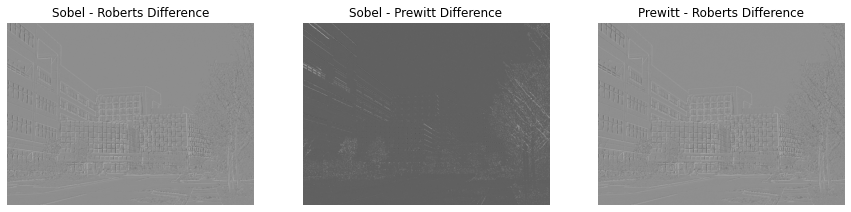

In [19]:
nat_arch_sobel_roberts_diff = nat_arch_edge_maps[1] - nat_arch_edge_maps[3]
nat_arch_sobel_prewitt_diff = nat_arch_edge_maps[1] - nat_arch_edge_maps[2]
nat_arch_prewitt_roberts_diff = nat_arch_edge_maps[2] - nat_arch_edge_maps[3]

# display the images
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 3,
                'figsize' : (15, 5),
                'images' : [nat_arch_sobel_roberts_diff, nat_arch_sobel_prewitt_diff, nat_arch_prewitt_roberts_diff],
                'titles' : ['Sobel - Roberts Difference',
                            'Sobel - Prewitt Difference',
                            'Prewitt - Roberts Difference']})

In the National Archives image example shown above, we confirm that the three edge detectors produce different results.

Try out the Roberts kernels instead

\begin{equation}
Roberts_x = \begin{bmatrix}
-1 & 1
\end{bmatrix}
\end{equation}

\begin{equation}
Roberts_y = \begin{bmatrix}
-1 \\
1
\end{bmatrix}
\end{equation}


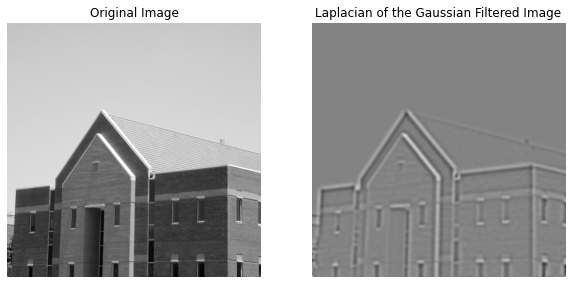

In [89]:
# trying to code up the Laplacion of Gaussian Edge Detector

# Step 1) Smooth the image with a Gaussian filter
sigma = 4

def round_up_to_odd(n):
    return ((np.ceil(n) // 2) * 2 + 1).astype(int)

# determine the size of the Gaussian kernel
n_gaussian = round_up_to_odd(6 * sigma)

# filter the image
img_bld_gaussian = skimage.filters.gaussian(img_building, sigma=sigma, truncate=4.0)

# Step 2) Compute the Laplacian of the smoothed image
img_building_gauss_lpl = skimage.filters.laplace(img_bld_gaussian)

# display the results so far before we attempt to find the zero crossings
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_building, img_building_gauss_lpl],
                'titles' : ['Original Image',
                            'Laplacian of the Gaussian Filtered Image']})

In [108]:
# Step 3) Find the zero crossings

# first compute the sign of the Laplacian image at each pixel location
lap_sign = np.sign(img_building_gauss_lpl)

# pad the laplacian sign array on both ends
#lap = np.pad(lap_sign, ((0,1), (0,1)))

# pad in the other direction
#lap_pad2 = np.pad(lap_sign, ((1,0), (1,0)))

# compute the deltas to see where the signs change
#diff_rows = np.logical_or(lap[:-1, :-1] - lap[:-1, 1:] < 0, lap[:-1, :-1] - lap[:-1, 1:] > 0)
#diff_cols = np.logical_or(lap[:-1, :-1] - lap[1:, :-1] < 0, lap[:-1, :-1] - lap[1:, :-1] > 0)

# Define Roberts kernels to compute the pairwise difference between pixels in each direction
roberts_hor = np.array([-1, 1]).reshape(1,-1)
roberts_ver = np.array([-1, 1]).reshape(-1,1)

sign_diff_hor = convolve(lap_sign, roberts_hor, mode='constant')
sign_diff_hor = np.logical_or(test_hor < 0, test_hor > 0)

sign_diff_ver = convolve(lap_sign, roberts_ver, mode='constant')
sign_diff_ver = np.logical_or(test_ver < 0, test_ver > 0)

zero_crss_hor_ver = np.logical_or(sign_diff_ver, sign_diff_hor)

Show the results so far with 4-neighborhood check only and no thresholding

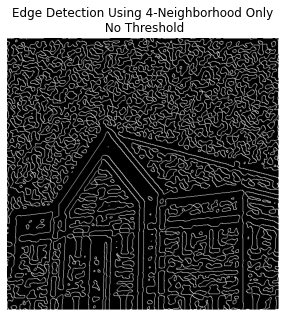

In [109]:
# display
plt.figure(figsize=(5,5))
plt.imshow(zero_crss_hor_ver, cmap='gray')
plt.title("Edge Detection Using 4-Neighborhood Only\n No Threshold")
plt.axis('off');


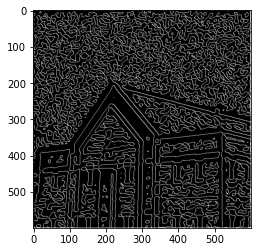

In [107]:
#roberts_hor = np.array([-1, 1]).reshape(1,-1)
#roberts_ver = np.array([-1, 1]).reshape(-1,1)

#test_hor = convolve(lap_sign, roberts_hor, mode='constant')
#test_hor = np.logical_or(test_hor < 0, test_hor > 0)

#test_ver = convolve(lap_sign, roberts_ver, mode='constant')
#test_ver = np.logical_or(test_ver < 0, test_ver > 0)

#test_combined = np.logical_or(test_ver,test_hor)
# display
#plt.imshow(test_combined, cmap='gray')

Next, we threshold our absolute differences to eliminate edges in areas of constant intensity (caused by image noise).
In the example below, the threshold is computed as 2% of the maximum Laplacian pixel value.

In [113]:
# pad the Laplacian image to compute the absolute value of the differences between the pixels
#lpl_pad = np.pad(img_building_gauss_lpl, ((0,1), (0,1)))
#lpl_pad_2 = np.pad(img_building_gauss_lpl, ((1,0), (1,0)))

# compute threshold
threshold = 0.02 * np.max(img_building_gauss_lpl)

# threshold Laplacian images along rows and columns
#rows_abs = np.abs(lpl_pad[:-1, :-1] - lpl_pad[:-1, 1:]) > threshold
#cols_abs = np.abs(lpl_pad[:-1, :-1] - lpl_pad[1:, :-1]) > threshold
rows_abs = convolve(img_building_gauss_lpl, roberts_hor, mode='constant') > threshold
cols_abs = convolve(img_building_gauss_lpl, roberts_ver, mode='constant') > threshold

# compute absolute differences
abs_thres_rows = np.logical_and(rows_abs, sign_diff_hor)
abs_thres_cols = np.logical_and(cols_abs, sign_diff_ver)

Now, let's take a look at our horizontal and vertical results individually and examine whether we were able to supress
the noise

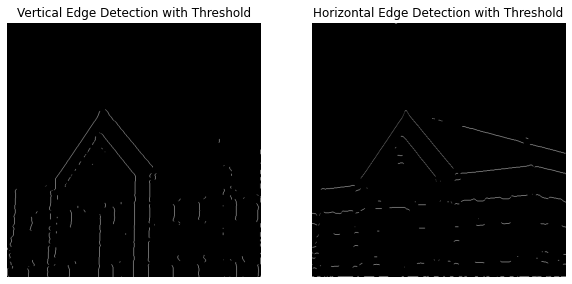

In [111]:
ec_img_utils.gray_img_comparison_plot({'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [abs_thres_rows, abs_thres_cols],
                'titles' : ['Vertical Edge Detection with Threshold',
                            'Horizontal Edge Detection with Threshold']})

Combine the 4-neighborhood edge maps into a single edge map

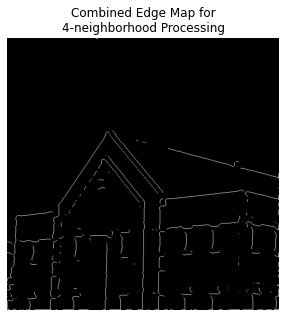

In [118]:
edge_4_neigh = np.logical_or(abs_thres_cols, abs_thres_rows)

# display the results
plt.figure(figsize=(5, 5))
plt.imshow(edge_4_neigh, cmap='gray')
plt.title("Combined Edge Map for\n4-neighborhood Processing")
plt.axis('off');

Next, we find the zero crossings along the diagonals

We can accomplish this by convolving our sign matrix with the following Roberts kernels.

\begin{equation}
Roberts_x = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
\end{equation}

\begin{equation}
Roberts_y = \begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}
\end{equation}

In [115]:
# POSITIVE DIAGONAL
zero_cr_pos_diag = skimage.filters.roberts_pos_diag(lap_sign)

# find the zero crossing pixels
zero_cr_pos_diag = np.logical_or(zero_cr_pos_diag > 0,zero_cr_pos_diag < 0)

# compute the absolute diagonal difference
pos_diag_abs_diff = np.abs(skimage.filters.roberts_pos_diag(img_building_gauss_lpl)) > threshold

# compute the positive diagonal zero crossings for the positive diagonal
pos_diag = np.logical_and(zero_cr_pos_diag, pos_diag_abs_diff)

# NEGATIVE DIAGONAL

# negative diagonal direction
zero_cr_neg_diag = skimage.filters.roberts_neg_diag(lap_sign)

# find the zero crossing pixels
zero_cr_neg_diag = np.logical_or(zero_cr_neg_diag > 0,zero_cr_neg_diag < 0)

# compute the absolute diagonal difference
neg_diag_abs_diff = np.abs(skimage.filters.roberts_neg_diag(img_building_gauss_lpl)) > threshold

# compute the positive diagonal zero crossings for the negative diagonal
neg_diag = np.logical_and(zero_cr_neg_diag, neg_diag_abs_diff)

Display the diagonal zero crossings so far

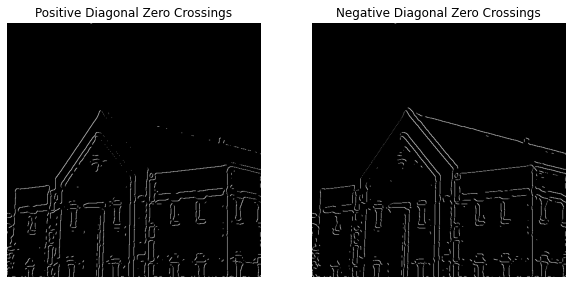

In [116]:
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [pos_diag, neg_diag],
                'titles' : ['Positive Diagonal Zero Crossings',
                            'Negative Diagonal Zero Crossings']})

Combine all zero crossings into a single edge map

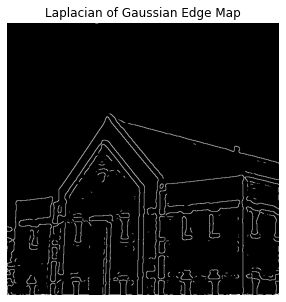

In [117]:
LoG_edge_map = np.logical_or(np.logical_or(pos_diag, neg_diag), edge_4_neigh)

# display the results
plt.figure(figsize=(5, 5))
plt.imshow(LoG_edge_map, cmap='gray')
plt.title("Laplacian of Gaussian Edge Map")
plt.axis('off');

Wrap the Laplacian of Gaussian algorithm into a function

In [119]:
def my_laplacian_of_gaussian(img, sigma, thresh_pct):
    # convert image to float, just in case
    img = skimage.img_as_float(img)

    # Step 1) Filter the image with the Gaussian kernel
    img_gaussian = skimage.filters.gaussian(img, sigma=sigma)

    # Step 2) Compute the Laplacian of the smoothed image
    img_gauss_lpl = skimage.filters.laplace(img_gaussian)

    # Step 3) Find the zero crossings

    # first compute the sign of the Laplacian image at each pixel location
    lapl_sign = np.sign(img_gauss_lpl)

    # pad the laplacian sign array on both ends
    # Define Roberts kernels to compute the pairwise difference between pixels in each direction
    roberts_hor_krnl = np.array([-1, 1]).reshape(1,-1)
    roberts_ver_krnl = np.array([-1, 1]).reshape(-1,1)

    diff_hor_sign = convolve(lapl_sign, roberts_hor_krnl, mode='constant')
    diff_hor_sign = np.logical_or(diff_hor_sign < 0, diff_hor_sign > 0)

    diff_ver_sign = convolve(lapl_sign, roberts_ver_krnl, mode='constant')
    diff_ver_sign = np.logical_or(diff_ver_sign < 0, diff_ver_sign > 0)

    #zero_crss_4_neigh_sign = np.logical_or(diff_ver_sign, diff_hor_sign)

    # THRESHOLD
    # compute threshold
    t = thresh_pct * np.max(img_gauss_lpl)

    # compute absolute differences
    hor_abs = convolve(img_gauss_lpl, roberts_hor_krnl, mode='constant') > t
    ver_abs = convolve(img_gauss_lpl, roberts_ver_krnl, mode='constant') > t

    # find zero crossings for 4-neighborhood
    abs_diff_hor = np.logical_and(hor_abs, diff_hor_sign)
    abs_diff_ver = np.logical_and(ver_abs, diff_ver_sign)

    # Combine the 4-neighborhood zero crossings from above and absolute differences
    zero_crss_4_neigh = np.logical_or(abs_diff_hor, abs_diff_ver)


    # POSITIVE DIAGONAL
    zero_cr_pos_dia = skimage.filters.roberts_pos_diag(lapl_sign)

    # find the zero crossing pixels
    zero_cr_pos_dia = np.logical_or(zero_cr_pos_dia > 0,zero_cr_pos_dia < 0)

    # compute the absolute diagonal difference
    pos_dia_abs_diff = np.abs(skimage.filters.roberts_pos_diag(img_gauss_lpl)) > t

    # compute the positive diagonal zero crossings for the positive diagonal
    pos_dia = np.logical_and(zero_cr_pos_dia, pos_dia_abs_diff)

    # NEGATIVE DIAGONAL

    # negative diagonal direction
    zero_cr_neg_dia = skimage.filters.roberts_neg_diag(lapl_sign)

    # find the zero crossing pixels
    zero_cr_neg_dia = np.logical_or(zero_cr_neg_dia > 0,zero_cr_neg_dia < 0)

    # compute the absolute diagonal difference
    neg_dia_abs_diff = np.abs(skimage.filters.roberts_neg_diag(img_gauss_lpl)) > t

    # compute the positive diagonal zero crossings for the negative diagonal
    neg_dia = np.logical_and(zero_cr_neg_dia, neg_dia_abs_diff)

    log_edge_map = np.logical_or(np.logical_or(pos_dia, neg_dia), zero_crss_4_neigh)

    return log_edge_map

Test my Laplacian of Gaussian Function

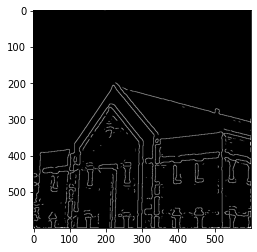

In [120]:
test_log = my_laplacian_of_gaussian(img_building, 4, 0.02)
plt.imshow(test_log, cmap='gray')

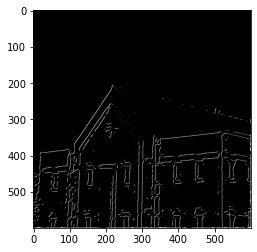

In [78]:
# firt diagonal direction
diag_1 = np.logical_or(lap[:-1, :-1] - lap[1:, 1:] < 0, lap[:-1, :-1] - lap[1:, 1:] > 0)
diag_abs = np.abs(lpl_pad[:-1, :-1] - lpl_pad[1:, 1:]) > threshold
abs_thres_diag_1 = np.logical_and(diag_abs, diag_1)

# second diagonal direction
diag_2 = np.logical_or(lap_pad2[:-1, :-1] - lap_pad2[1:, 1:] < 0, lap_pad2[:-1, :-1] - lap_pad2[1:, 1:] > 0)
diag_abs_2 = np.abs(lpl_pad_2[:-1, :-1] - lpl_pad_2[1:, 1:]) > threshold
abs_thres_diag_2 = np.logical_and(diag_abs_2, diag_2)

# display the results
plt.figure(figsize=(5, 5))
plt.imshow(abs_thres_diag_1, cmap='gray')
plt.title("Zero Crossings Along\nDiagonal Direction 1")
plt.axis('off');

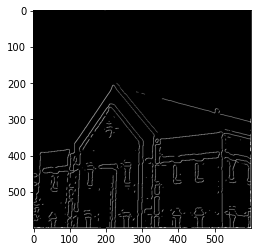

In [79]:
#combined_2 = np.logical_or(combined, abs_thres_diag_1)
#plt.imshow(combined_2, cmap='gray')

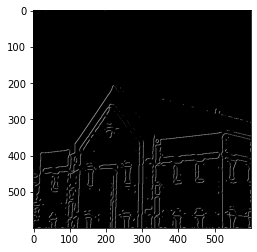

In [80]:
# try diagonals in the other direction
diag_2 = np.logical_or(lap_pad2[:-1, :-1] - lap_pad2[1:, 1:] < 0, lap_pad2[:-1, :-1] - lap_pad2[1:, 1:] > 0)

diag_abs_2 = np.abs(lpl_pad_2[:-1, :-1] - lpl_pad_2[1:, 1:]) > threshold

abs_thres_diag_2 = np.logical_and(diag_abs_2, diag_2)

plt.imshow(abs_thres_diag_2, cmap='gray')

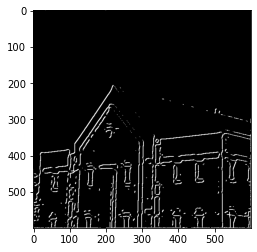

In [82]:
diff =np.abs(abs_thres_diag_2.astype(int) - abs_thres_diag_1.astype(int))
plt.imshow(diff, cmap='gray')

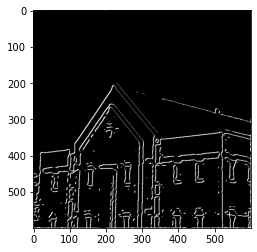

In [83]:
# combine them all
combined_3 = np.logical_or(combined_2, abs_thres_diag_2)
plt.imshow(combined_3, cmap='gray')